In [1]:
# Importa las librerias NumPy y TensorFlow,
# y verifica si hay GPU disponible

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
N = 1024 # Longitud de bloque
K = 512 # Rate 1/2
CRC_tipo = "CRC24A" # CRC de 24 bits, seccion 5.1 3GPP TS 38.212
K_datos = 488 # K - CRC

In [3]:
# Generador 'dummy' de bits congelados

import csv

digits = np.random.permutation(N)[:(N-K)]
with open('random_digits.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(digits)

In [4]:
# Crea un Codificador Polar con concatenación CRC

from sionna.phy.fec.polar.encoding import PolarEncoder
from sionna.phy.fec.crc import CRCEncoder

CRC_codif = CRCEncoder(CRC_tipo)
bits_congelados = np.loadtxt('random_digits.csv', delimiter=',', dtype=int)
polar_codif = PolarEncoder(bits_congelados, N) # crea instancia de Codificador Polar

datos = tf.random.uniform([1, K_datos], minval=0, maxval=2, dtype=tf.int32)
datos = tf.cast(datos, tf.float32)  # crea como entrada K_datos valores aleatorios entre 0 y 1

data_con_crc = CRC_codif(datos)
bits_codif = polar_codif(data_con_crc)  # incluye bits CRC

print(datos.shape)  # debería ser (1, 488)
print(bits_codif.shape)  # debería ser (1, 1024)
bits_codif

I0000 00:00:1747157096.426849    2400 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9581 MB memory:  -> device: 0, name: NVIDIA RTX 3500 Ada Generation Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


(1, 488)
(1, 1024)


<tf.Tensor: shape=(1, 1024), dtype=float32, numpy=array([[0., 1., 1., ..., 0., 0., 0.]], dtype=float32)>

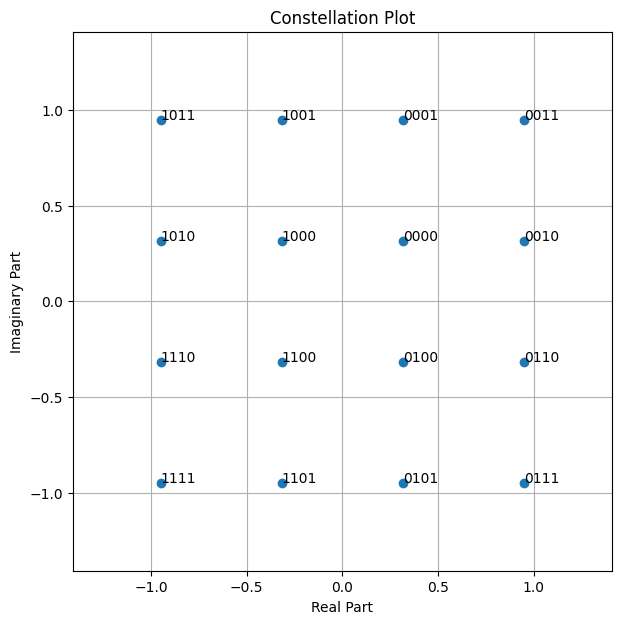

In [5]:
# Bloques de mapeo/demapeo de simbolos

from sionna.phy.mapping import Constellation
from sionna.phy.mapping import Mapper
from sionna.phy.mapping import Demapper

bitsxsimb = 4
constelacion = Constellation("qam", bitsxsimb)  # mapeo QAM 4-bits
constelacion.show()
mapeador = Mapper(constellation=constelacion)  # instancia del mapeador
x = mapeador(bits_codif)  # mapea bits a símbolos complejos
demapeador = Demapper("app",constellation=constelacion)  # instancia del demapeador

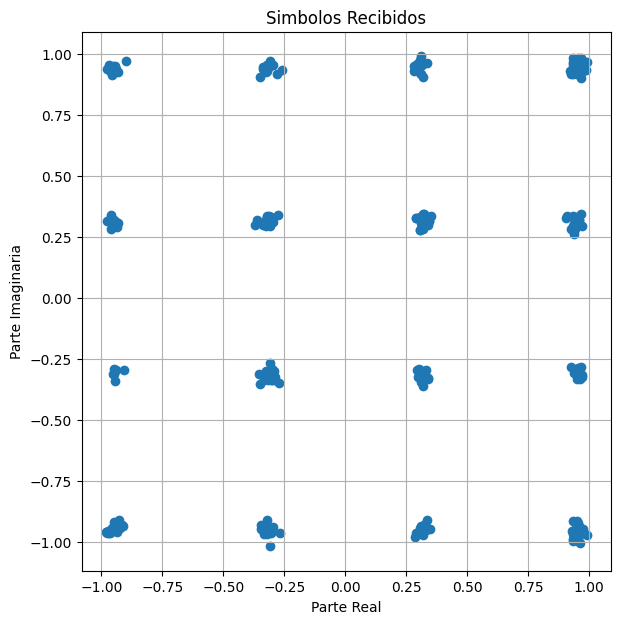

In [6]:
# Opcion 1: canal AWGN
from sionna.phy.channel import AWGN
from sionna.phy.utils import ebnodb2no

awgn = AWGN()  # instancia del canal AWGN
ebno_db = 25  # dB
no = ebnodb2no(ebno_db, bitsxsimb, coderate=1)  # ruido
y = awgn(x, no)  # salida del canal
llr = demapeador(y, no)  # LLR de salida del demapeador

# Visualiza señal recibida
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
plt.scatter(np.real(y), np.imag(y));
ax.set_aspect("equal", adjustable="box")
plt.xlabel("Parte Real")
plt.ylabel("Parte Imaginaria")
plt.grid(True, which="both", axis="both")
plt.title("Simbolos Recibidos");

In [8]:
# Crea un Decodificador Polar de tipo SCL

from sionna.phy.fec.polar.decoding import PolarSCLDecoder
from sionna.phy.fec.crc import CRCDecoder

lista = 8
polar_decodif = PolarSCLDecoder(bits_congelados, N, list_size=lista)
CRC_decodif = CRCDecoder(crc_encoder=CRC_codif)
words_decodif = polar_decodif(llr)
bits_decodif, crc_ok = CRC_decodif(words_decodif)

print(bits_decodif.shape)  # debería ser (1, 488)
print(crc_ok.shape)  # debería ser (1, 1)

/home/sergio/miniconda3/envs/tf/lib/python3.12/site-packages/sionna/phy/fec/polar/decoding.py:415: UserWarning: Required resource allocation is large for the selected blocklength. Consider option `cpu_only=True`.
  warnings.warn("Required resource allocation is large " \


(1, 488)
(1, 1)
